## Initialise dependencies

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Utils

### Function to calculate derivative

In [2]:
class DerivativeError(Exception):
    def __init__(self, message):
        super().__init__(message)

def calculate_difference(points):
    d_points = []
    for i in range(0,len(points)-1):
        p1 = points[i]
        p2 = points[i+1]
        d_points.append(p2-p1)
    return d_points
    
def differentiate(x, y):
    if len(x) != len(y):
        raise DerivativeError('Unequal datapoints in the dataset')
    d_x = calculate_difference(x)
    d_y = calculate_difference(y)
    return np.divide(d_y, d_x)

## Engineering Strain v/s Engineering Stress

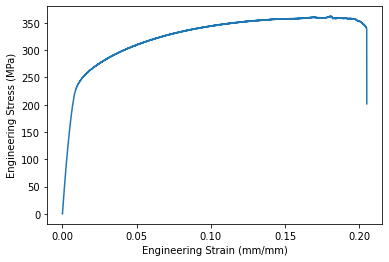

In [3]:
x_label = 'Engineering Strain (mm/mm)'
y_label = 'Engineering Stress (MPa)'
dataset = pd.read_csv('./tensile_test_data.csv', sep='\t', names=[x_label, y_label])
x = dataset[x_label]
y = dataset[y_label]
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.plot(x,y)

### Fit a linear curve onto the seemingly straight line

Young's Modulus: 28.343567180375043 GPa


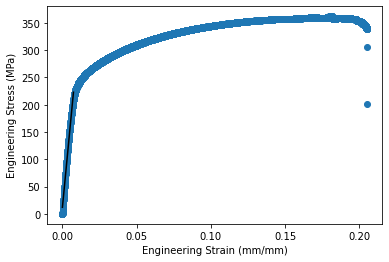

In [4]:
point_until_straight = 698 # point upto which the curve seems straight
coefs = np.polyfit(x[:point_until_straight], y[:point_until_straight], 1)
plt.figure()
y_fit = np.polyval(coefs, x[:point_until_straight])
a = plt.plot(x[:point_until_straight], y_fit, color='black')
plt.scatter(x,y)
plt.xlabel(x_label)
plt.ylabel(y_label)
# The line formed is straight so it does not matter which coordinates are taken
youngs_modulus = (y_fit[100]-y_fit[99])/(x[100]-x[99])
print(f'Young\'s Modulus: {youngs_modulus/1000} GPa')

### Calculating Yield Strength 

Yield Strength: 236.48302 MPa


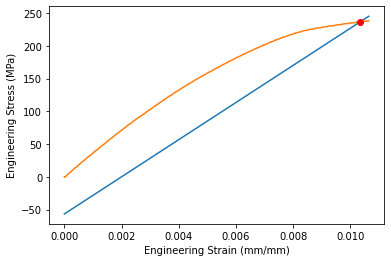

In [5]:
required_points = 1000
parallel_line_y = [(i - 0.002)*youngs_modulus for i in x[:required_points]]
plt.plot(x[:required_points], parallel_line_y)
plt.plot(x[:required_points],y[:required_points])
intersection = np.argwhere(np.diff(np.sign(parallel_line_y - y[:required_points]))).flatten()
plt.plot(x[intersection], y[intersection], 'ro')
plt.xlabel(x_label)
plt.ylabel(y_label)

# 0th index because there is only one intersection point
print(f'Yield Strength: {y[intersection[0]]} MPa')

### Calculating Ultimate Tensile Strength

Ultimate Tensile Strength is 362.27072 MPa at 18.095% elongation.


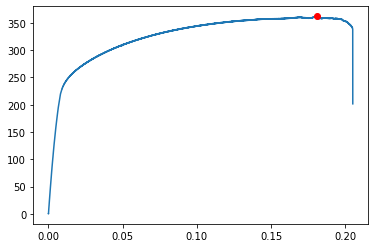

In [9]:
# Fetch the max value of the engineering stress from the dataset.
uts_abscissa = 0
uts = y[uts_abscissa]
for i in range(0,len(y)):
    if y[i] >= uts:
        uts = y[i]
        uts_abscissa = i
uts_strain = x[uts_abscissa]
plt.plot(x,y)
plt.plot(uts_strain, uts, 'ro')
print(f'Ultimate Tensile Strength is {uts} MPa at {uts_strain*100}% elongation.')